**SRGANs to convert Low Resolution Images to High Resolution Images**

The GAN network was constructed by referring to the generator and discriminator architecture diagram in the paper: **"Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial
Network"**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [ ]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Assigining training dataset to a variable
data_dir_train = '/content/drive/MyDrive/Job Opportunity - 2/Div2k dataset/DIV2K_train_HR/DIV2K_train_HR'



In [ ]:
#Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Check if images are in supported format for tensorflow
j=0 #Counter to check how many images are removed
for image in os.listdir(data_dir_train):
  image_path = os.path.join(data_dir_train, image)
  with tf.io.gfile.GFile(image_path, 'rb') as f: #Read images in binary fomat
    image_data = f.read()

    # Decode image
    try:
      image = tf.io.decode_image(image_data)
      print("Image is in a supported format.")
    except:
      print("Image is not in a supported format.")
      j = j+1
      os.remove(image_path)
print(j)

In [ ]:
#Converting images from png to jpeg
for image in os.listdir(data_dir_train):
  if image.endswith('.png'):
    new_file_name = os.path.join(data_dir_train,image.replace(".png",".jpeg"))
    os.rename(os.path.join(data_dir_train,image),new_file_name)


Performing Data Augmentation

In [ ]:
#Assigning appropriate folder paths to variables...ImageDataGenerator requires subdirectories
data_dir = '/content/drive/MyDrive/Job Opportunity - 2/Div2k dataset/DIV2K_train_HR'
data_dir_train = '/content/drive/MyDrive/Job Opportunity - 2/Div2k dataset/DIV2K_train_HR/DIV2K_train_HR'



In [ ]:
#Data Augmentation variable - We do not perform any rotations or flipping to ensure no loss of spatial information
augmentation_generator = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode = 'reflect',  #Random cropping function
    preprocessing_function = lambda x: x #Function to ensure the quality of the iamge remains the same, no further preprocessing (x - input image: x - returns same quality input image)
)

# Data augmentation for high-resolution images
datagen = augmentation_generator.flow_from_directory(
    data_dir,
    shuffle=False,  # Do not shuffle the data to keep the original order
    save_to_dir=data_dir_train,  # Save augmented images in the same directory
    save_format='jpeg',
    batch_size=1
)

num_augmented_images = 2  #2 augmentations per image

for i in range(num_augmented_images):
  for j in range(len(datagen)):
    # Generate augmented high-resolution images
    datagen.next()

Found 800 images belonging to 1 classes.


In [ ]:
print(len(os.listdir(data_dir_train)))


2400


Splitting the dataset to high resolution images and low resolution images


In [ ]:
hr_images = '/content/drive/MyDrive/Job Opportunity - 2/Div2k dataset/HighResolution&LowResolution/hr_images'
lr_images = '/content/drive/MyDrive/Job Opportunity - 2/Div2k dataset/HighResolution&LowResolution/lr_images'

# Define the target size for high-resolution images
hr_target_size = (128, 128)

# Define the target size for low-resolution images
lr_target_size = (32, 32)

# Create directories to store low-resolution and high-resolution images
os.makedirs(hr_images, exist_ok=True)
os.makedirs(lr_images, exist_ok=True)

# Function to resize and save images without padding
def resize_and_save(src_path, dest_path, target_size):
    for img_file in os.listdir(src_path):
        img_path = os.path.join(src_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize the image to the target size
        img_resized = cv2.resize(img, target_size)

        # Save the preprocessed image
        dest_img_path = os.path.join(dest_path, img_file)
        cv2.imwrite(dest_img_path, img_resized)





In [ ]:
# Resize and save high-resolution images
resize_and_save(data_dir_train, hr_images, hr_target_size)

# Resize and save low-resolution images
resize_and_save(data_dir_train, lr_images, lr_target_size)

In [ ]:
print(len(os.listdir(hr_images)))
print(len(os.listdir(lr_images)))

2400
2400


Building Model

In [ ]:
#Importing necessary libraries to make generator and discriminator
from keras.models import Sequential
from keras import layers, Model
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten #PReLU for generator
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add #LeakyReLU for discriminator
from tqdm import tqdm

Generator Building Blocks

In [ ]:
#Residual Block for skip connnections
def res_block(ip):
  res_model = Conv2D(64, (3,3), padding = 'same')(ip)
  res_model = BatchNormalization(momentum=0.99)(res_model)
  res_model = PReLU(shared_axes = [1,2])(res_model) #PReLU is used to learn negative inputs

  res_model = Conv2D(64, (3,3), padding='same')(res_model)
  res_model = BatchNormalization(momentum=0.99)(res_model)

  return add([ip, res_model]) #Concatenating the input and output from residual model

#Upscale Block to scale the images up
def upscale_block(ip):
  up_model = Conv2D(256, (3,3), padding="same")(ip)
  up_model = UpSampling2D(size=2)(up_model)
  up_model = PReLU(shared_axes=[1,2])(up_model)

  return up_model


In [ ]:
#Generator Model
def create_gen(gen_ip, num_res_block):
  layers = Conv2D(64, (9,9), padding="same")(gen_ip)
  layers = PReLU(shared_axes=[1,2])(layers)

  temp = layers #Variable placed as the input needs to be provided to the residual block at the end

  for i in range(num_res_block):
    layers = res_block(layers)

  layers = Conv2D(64, (3,3), padding="same")(layers)
  layers = BatchNormalization(momentum=0.99)(layers)
  layers = add([layers, temp]) #Input added to residual model

  layers = upscale_block(layers)
  layers = upscale_block(layers)


  op = Conv2D(3, (9,9), padding="same")(layers) #n=3 since it is an RGB image

  return Model(inputs=gen_ip, outputs = op)




Discriminator Blocks

In [ ]:
#Discriminator function that will be used to consturct the discriminator network
def discriminator_block(ip, filters, strides=1, bn=True):
  disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

  #Batch_normalization kept in if function as the 1st block in the discriminator network does not contain a batch_normalization layer
  if bn:
    disc_model = BatchNormalization(momentum=0.99)(disc_model)

  disc_model = LeakyReLU(alpha=0.2)(disc_model)

  return disc_model

In [ ]:
#Discriminator as shown in discriminator architecture diagram
def create_disc(disc_ip):

  df = 64

  d1 = discriminator_block(disc_ip, df, bn=False)
  d2 = discriminator_block(d1, df, strides=2)
  d3 = discriminator_block(d2, df*2)
  d4 = discriminator_block(d3, df*2, strides=2)
  d5 = discriminator_block(d4, df*4)
  d6 = discriminator_block(d5, df*4, strides=2)
  d7 = discriminator_block(d6, df*8)
  d8 = discriminator_block(d7, df*8, strides=2)

  d8_5 = Flatten()(d8)
  d9 = Dense(df*16)(d8_5)
  d10 = LeakyReLU(alpha=0.2)(d9)
  validity = Dense(1, activation='sigmoid')(d10) #Giving a binary output to tell if its a real or fake image

  return Model(disc_ip, validity)

In [ ]:
from keras.applications import VGG19


In [ ]:
#Vgg network to extract feature maps of the image in order to get accurate generation of images
def build_vgg(hr_shape):
  vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

  return Model(inputs = vgg.inputs, outputs=vgg.layers[20].output)
  #vgg.layers[20] is last conv layer at block 5 in the vgg network

In [ ]:
#Combined  GAN model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
  gen_img = gen_model(lr_ip) #Takes low resolution image as input to generate high res images
  gen_features = vgg(gen_img) #vgg network used to extract image features

  disc_model.trainable = False
  validity = disc_model(gen_img) #Discriminator takes the generated image as input

  return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features]) #Validity - Adversial Loss || gen_features - Content Loss(VGG19)

*Preprocessing*

In [ ]:
lr_list = os.listdir(lr_images) #Getting the low resolution images in a variable
# lr_list

In [ ]:
hr_list = os.listdir(hr_images) #Getting the high resolution images in a variable
# hr_list

In [ ]:
lr_imgs = []
for imgs in lr_list:
  img_path = os.path.join(lr_images, imgs)
  img_hr = cv2.imread(img_path)
  img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB) #opencv reads as bgr..converting to rgb for display purposes
  lr_imgs.append(img_hr)

In [ ]:
hr_imgs = []
for imgs in hr_list:
  img_path = os.path.join(hr_images, imgs)
  img_hr = cv2.imread(img_path)
  img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB) #opencv reads as bgr..converting to rgb for display purposes
  hr_imgs.append(img_hr)

In [ ]:
#Converting images into arrays for processing in the models
lr_imgs = np.array(lr_imgs)
hr_imgs = np.array(hr_imgs)

In [ ]:
hr_imgs.shape

(2400, 128, 128, 3)

Visualizing Data


In [ ]:
import random
import numpy as np

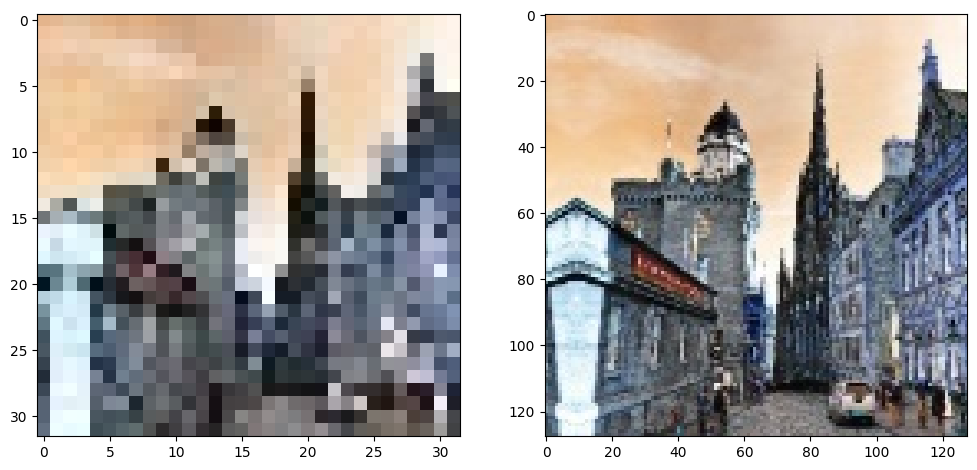

In [ ]:
#Visualize inputs
image_number = random.randint(0, len(lr_imgs)-1)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(lr_imgs[image_number], (32,32,3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_imgs[image_number], (128,128,3)))
plt.show()

In [ ]:
#Rescaling the images
lr_imgs = lr_imgs/255
hr_imgs = hr_imgs/255

In [ ]:
lr_imgs[0].shape

(32, 32, 3)

In [ ]:
#Getting the shape of the image (height, width, channels)
hr_shape = (hr_imgs.shape[1], hr_imgs.shape[2], hr_imgs.shape[3])
lr_shape = (lr_imgs.shape[1], lr_imgs.shape[2], lr_imgs.shape[3])

In [ ]:
print(hr_shape)
print(lr_shape)

(128, 128, 3)
(32, 32, 3)


In [ ]:
#Creating input layer for high resolution and low resolution images
hr_ip = Input(shape=hr_shape)
lr_ip = Input(shape=lr_shape)


In [ ]:
hr_ip

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
#Creating the generator network, sending the low resolution images as input
generator = create_gen(lr_ip, num_res_block=16) #16 identical residual blocks as mentioned in the paper
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_2[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [ ]:
#Creating the discriminator block getting the high resolution images as input
discriminator = create_disc(hr_ip)
discriminator.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [ ]:
#We use the vgg to extract features from the actual high resolution image and the generated high resolution image for comparison
vgg = build_vgg((128,128,3)) #input of vgg is 256,256 and we need it the same size of the high res images to extract the features from the image
print(vgg.summary())
vgg.trainable = False

80134624/80134624 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                            

In [ ]:
#Creating the GAN, combinig the generator, discriminator and the vgg block to extract features
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

In [ ]:
#We use binary-crossentropy for output of discriminator and mse for the generated features in vgg
gan_model.compile(loss=['binary_crossentropy','mse'],loss_weights=[1e-3, 1], optimizer = 'adam')

In [ ]:
#Creating an array of 2 images at a time and supplying it to the network
batch_size = 1
train_hr_batches = []
train_lr_batches = []

for it in range(int(hr_imgs.shape[0]/ batch_size)):
  start_index = it*batch_size
  end_index = start_index + batch_size
  train_hr_batches.append(hr_imgs[start_index:end_index])
  train_lr_batches.append(lr_imgs[start_index:end_index])

In [ ]:
epochs = 15 #Only training 15 epochs due to GPU limitations
k=1 #Alternate updates between discriminator and generator

for e in range(epochs):
  fake_label = np.zeros((batch_size,1)) #Assign 0s to fake images
  real_label = np.ones((batch_size,1)) #Assign 1 to real images

  #Create empty lists for generator loss and discriminator loss
  g_losses = []
  d_losses = []


  for b in tqdm(range(len(train_hr_batches))):
    lr_image = train_lr_batches[b] #Getting a batch of low resolution images
    hr_image = train_hr_batches[b] #Getting a batch of high resolution images


    for _ in range(k):
      fake_images = generator.predict_on_batch(lr_image) #Fake images

      #Training the discriminator on fake and real high resolution images
      discriminator.trainable = True
      d_loss_gen = discriminator.train_on_batch(fake_images, fake_label)
      d_loss_real = discriminator.train_on_batch(hr_image, real_label)

      #Average the disciminator purposes
      d_loss = 0.5*np.add(d_loss_gen, d_loss_real)


    for _ in range(k):
      #Extracting image features
      image_features = vgg.predict(hr_image)

      #Making the discriminator non-trainable to train generator
      discriminator.trainable = False

      #Train the generator via GAN
      #2 losses, adversial loss and content loss(VGG)
      g_loss, _, _ = gan_model.train_on_batch([lr_image, hr_image], [real_label, image_features])

    #Saving losses to a list to average
    d_losses.append(d_loss)
    g_losses.append(g_loss)

  #Convert the list of losses to an array
  g_losses = np.array(g_losses)
  d_losses = np.array(d_losses)

  #Calculate avg. losses of generator and discriminator
  g_loss = np.sum(g_losses, axis=0)/ len(g_losses)
  d_loss = np.sum(d_losses, axis=0)/ len(d_losses)

  print("epoch:", e+1, "g_loss:", g_loss, "d_loss:", d_loss)

  #Save model after 10 epochs
  if e==5:
    generator.save('/content/drive/MyDrive/Job Opportunity - 2/generator_9.h5')





In [ ]:
#Save model
generator.save('/content/drive/MyDrive/Job Opportunity - 2/generator_8.h5')

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [ ]:
#Loading saved model
from keras.models import load_model
from numpy.random import randint
generator = load_model('/content/drive/MyDrive/Job Opportunity - 2/generator_8.h5', compile=False)

In [ ]:
#Assigning appropriate folders for test images output
test_images_dir = '/content/drive/MyDrive/Job Opportunity - 2/test_images_'
test_images_hr = '/content/drive/MyDrive/Job Opportunity - 2/test_images_hr'
test_images_lr = '/content/drive/MyDrive/Job Opportunity - 2/test_images_lr'

test_images_output = '/content/drive/MyDrive/Job Opportunity - 2/test_images_output'





In [ ]:
#Converting images from png to jpeg
for image in os.listdir(test_images_dir):
  if image.endswith('.png'):
    new_file_name = os.path.join(test_images_dir,image.replace(".png",".jpeg"))
    os.rename(os.path.join(test_images_dir,image),new_file_name)


In [ ]:
if not os.path.exists(test_images_hr):
  os.makedirs(test_images_hr)

if not os.path.exists(test_images_lr):
  os.makedirs(test_images_lr)

if not os.path.exists(test_images_output):
  os.makedirs(test_images_output)


In [ ]:
#Converting to hr and lr images
resize_and_save(test_images_dir, test_images_hr, hr_target_size)
resize_and_save(test_images_dir, test_images_lr, lr_target_size)

In [ ]:
len(os.listdir(test_images_lr))

6

In [ ]:
#Apporpriate preprocessing steps
lr_list_test = os.listdir(test_images_lr)
hr_list_test = os.listdir(test_images_hr)

lr_imgs_test = []
for imgs in lr_list_test:
  img_path = os.path.join(test_images_lr, imgs)
  img_lr = cv2.imread(img_path)
  img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
  lr_imgs_test.append(img_lr)

hr_imgs_test = []
for imgs in hr_list_test:
  img_path = os.path.join(test_images_hr, imgs)
  img_hr = cv2.imread(img_path)
  img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
  hr_imgs_test.append(img_hr)

lr_imgs_test = np.array(lr_imgs_test)
hr_imgs_test = np.array(hr_imgs_test)

lr_imgs_test = lr_imgs_test/255
hr_imgs_test = hr_imgs_test/255

1/1 [==============================] - 1s 912ms/step


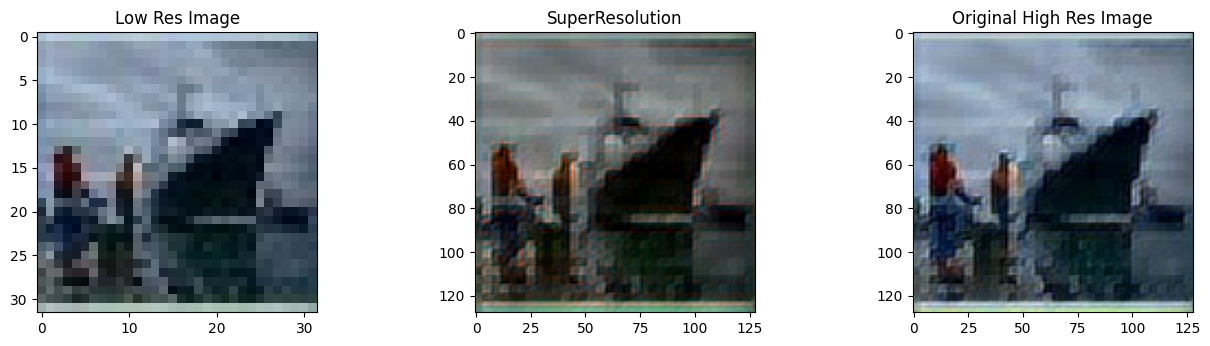

1/1 [==============================] - 2s 2s/step


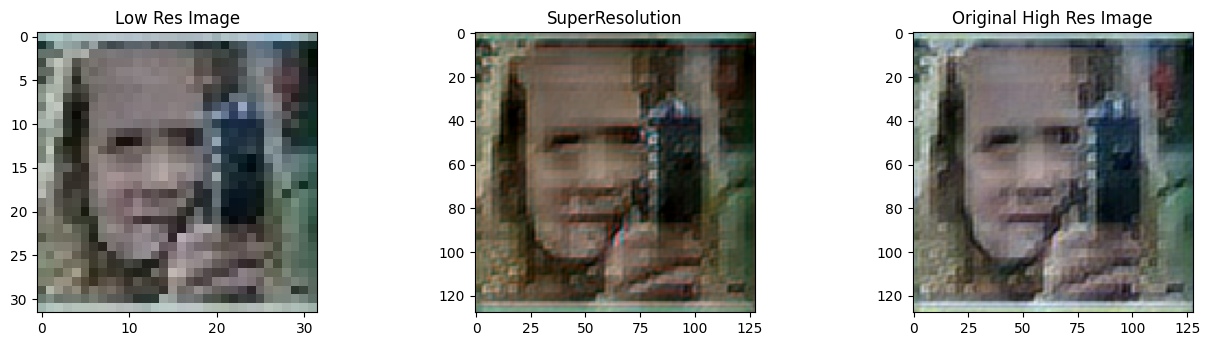

1/1 [==============================] - 1s 909ms/step


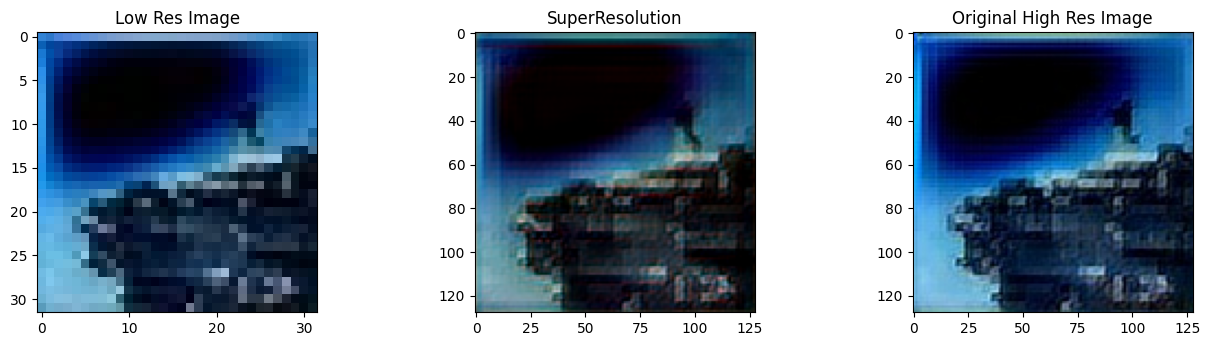

1/1 [==============================] - 1s 848ms/step


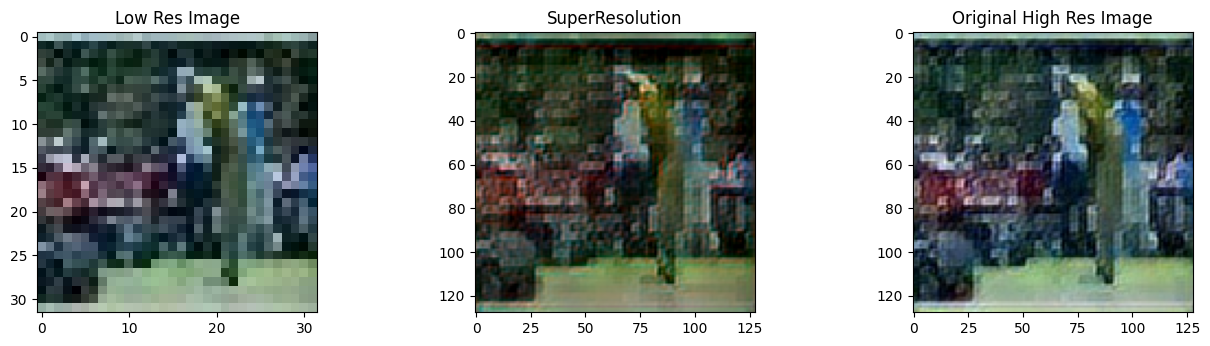

1/1 [==============================] - 1s 907ms/step


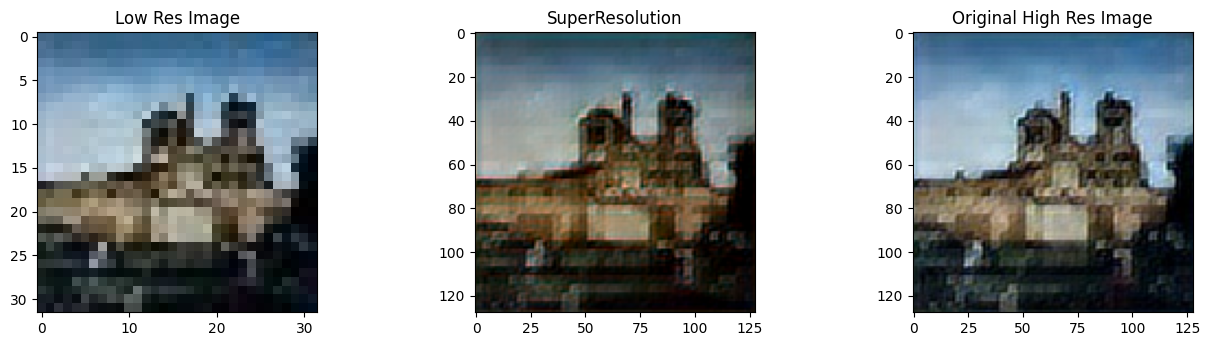

1/1 [==============================] - 1s 1s/step


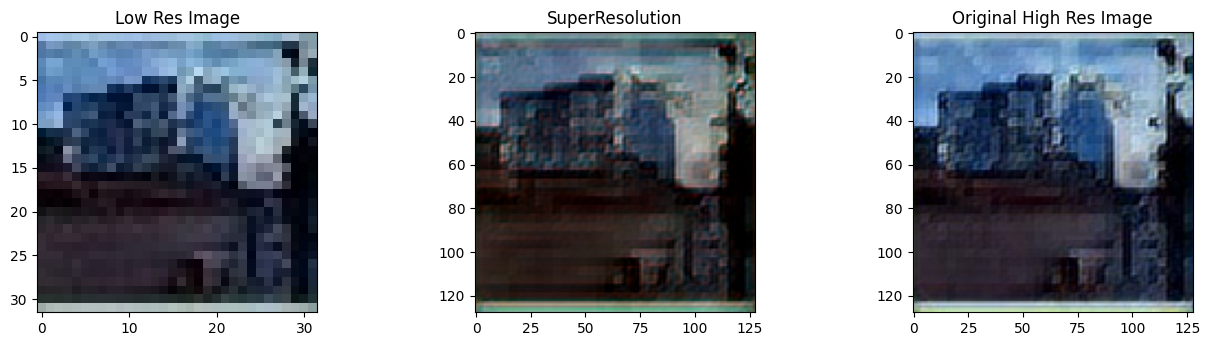

In [ ]:
#Prediction for each test image with display of outputs
for i in range(len(lr_imgs_test)):
  src_image = np.expand_dims(lr_imgs_test[i], axis=0) #Expanding array size for prediction
  gen_image = generator.predict(src_image)
  gen_image = np.squeeze(gen_image, axis=0) #Removing a dimension for visualization

  img_filename = lr_list_test[i]

  save_path = os.path.join(test_images_output, f"{img_filename}")
  gen_image = np.clip(gen_image * 255, 0 , 255).astype(np.uint8)  #Ensuring values range from 0-255
  cv2.imwrite(save_path, cv2.cvtColor(gen_image, cv2.COLOR_RGB2BGR))

  #Displaying Image
  plt.figure(figsize=(16,8))
  plt.subplot(231)
  plt.title('Low Res Image')
  plt.imshow(lr_imgs_test[i])
  plt.subplot(232)
  plt.title('SuperResolution')
  plt.imshow(gen_image)
  plt.subplot(233)
  plt.title('Original High Res Image')
  plt.imshow(hr_imgs_test[i])
  plt.show()


In [ ]:
#Converting to png format
for image in os.listdir(test_images_output):
  if image.endswith('.jpeg'):
    new_file_name = os.path.join(test_images_output,image.replace(".jpeg",".png"))
    os.rename(os.path.join(test_images_output,image),new_file_name)


In [ ]:
print(os.listdir(test_images_output))

['test_image_5.png', 'test_image_1.png', 'test_image_4.png', 'test_image_2.png', 'test_image_6.png', 'test_image_3.png']
